This notebook shows a very simple neuronal network to solve PIMA classification problem

## Import statements

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from helpers import *

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score

from keras.utils.vis_utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


from itertools import count

%matplotlib inline

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

## Import dataset

In [64]:
# Read the dataset
data = load_dataset()

# Preprocess the dataset
preprocess(data)

# Split dataset in two arrays: X for features and y for labels
X = get_features(data)
y = get_outcome(data)
y_cat = get_categorical_outcome(data)

## Build our neural network

### Parameters configuration

In [41]:

# This variable contains information about the topology of our neural network:
# Number of cells on each layer, number of layers and activation function
layers = [
    # Input layer
    {
        'units': 8,
        'activation': 'tanh',
        'bias': True
    },
    ## Hidden layers
    #
    {
        'units': 16,
        'activation': 'tanh',
        'bias': True
    },
    #
    
    # Output layer
    {
        'units': 2,
        'activation': 'softmax',
        'bias': True
    }
]

# Loss function
loss = 'categorical_crossentropy'

# Optimizer to be used to minimize cost
#optimizer = Adam(lr=0.032)
#optimizer = SGD(lr=0.01)
optimizer = SGD(lr=0.02)


### Create the model

In [74]:
# This is a helper class to create our neural network with the parameters defined above

class NeuralNetwork(Sequential):
    def __init__(self):
        super().__init__(name='PIMA classifier')
        
        first_layer = layers[1]
        self.add(Dense(units=first_layer['units'], activation=first_layer['activation'], use_bias=first_layer['bias'],
                       input_shape=(len(X.columns),), name='Input_Layer'))

        for index, layer in zip(count(1), layers[1:]):
            self.add(Dense(units=layer['units'], activation=layer['activation'], use_bias=layer['bias'],
                          name='Hidden_Layer{}'.format(index) if index < len(layers) - 1 else 'Output_Layer'))
    
    def compile(self):
        return super().compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
        
    def predict(self, X, **kwargs):
        return np.reshape(np.argmax(super().predict(X), axis=1), (X.shape[0],1))
    
    @classmethod
    def wrapper(cls, *args, **kwargs):
        def build():
            model = cls()
            model.compile()
            return model
        return KerasClassifier(build_fn=build, **kwargs)
    
    def plot(self):
        return SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

### Our model summary

In [43]:
model = NeuralNetwork()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (Dense)          (None, 16)                144       
_________________________________________________________________
Hidden_Layer1 (Dense)        (None, 16)                272       
_________________________________________________________________
Output_Layer (Dense)         (None, 2)                 34        
Total params: 450
Trainable params: 450
Non-trainable params: 0
_________________________________________________________________


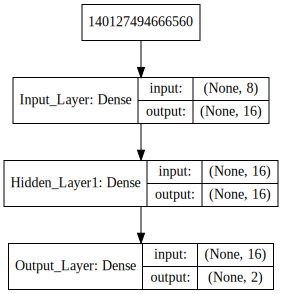

In [44]:
model.plot()

### Test the model without cross-validation

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=22, stratify=y)
model = NeuralNetwork()
model.compile()
history = model.fit(X_train, y_train, verbose=False, epochs=50, validation_split=0.1)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('Training phase completed')

Training phase completed


### Print results

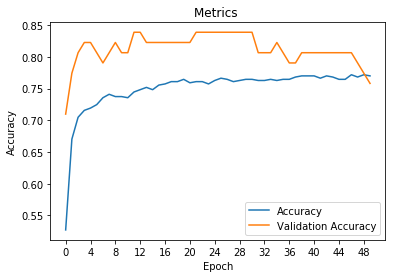

In [76]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(0, 50, 4));
plt.title('Metrics ')
plt.legend(['Accuracy', 'Validation Accuracy']);

In [48]:
# Print accuracy score, classification report and confusion matrix on train
print("Accuracy score predicting all have diabetes: {:2f}\n".format(accuracy_score(y_train, y_train_pred)))
print(classification_report(y_train, y_train_pred))

pd.DataFrame(data=confusion_matrix(y_train, y_train_pred), columns=['Predict no diabetes', 'Predict diabetes'],
            index=['Not have diabetes', 'Have diabetes'])

Accuracy score predicting all have diabetes: 0.773616

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       400
           1       0.71      0.59      0.64       214

   micro avg       0.77      0.77      0.77       614
   macro avg       0.76      0.73      0.74       614
weighted avg       0.77      0.77      0.77       614



,Predict no diabetes,Predict diabetes
Not have diabetes,349,51
Have diabetes,88,126


In [50]:
# Print accuracy score, classification report and confusion matrix on test
print("Accuracy score predicting all have diabetes: {:2f}\n".format(accuracy_score(y_test, y_test_pred)))
print(classification_report(y_test, y_test_pred))

pd.DataFrame(data=confusion_matrix(y_test, y_test_pred), columns=['Predict no diabetes', 'Predict diabetes'],
            index=['Not have diabetes', 'Have diabetes'])

Accuracy score predicting all have diabetes: 0.811688

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       100
           1       0.77      0.67      0.71        54

   micro avg       0.81      0.81      0.81       154
   macro avg       0.80      0.78      0.79       154
weighted avg       0.81      0.81      0.81       154



,Predict no diabetes,Predict diabetes
Not have diabetes,89,11
Have diabetes,18,36


## Cross-validate the model

In [126]:
model = NeuralNetwork.wrapper(epochs=20, verbose=False)

#cv = StratifiedKFold(6, shuffle=True, random_state=13)
#cv = KFold(5)
#cross_val_score(model, X, y, scoring='accuracy', cv=cv)
cv = RepeatedStratifiedKFold(4, 3, random_state=13)

cv_results = cross_validate(model, X, y, scoring=['accuracy', 'precision', 'recall'], cv=cv, return_train_score=True);

In [152]:
cv_metrics = pd.DataFrame(data=cv_results).drop(columns=['score_time', 'fit_time'])

### Show the results

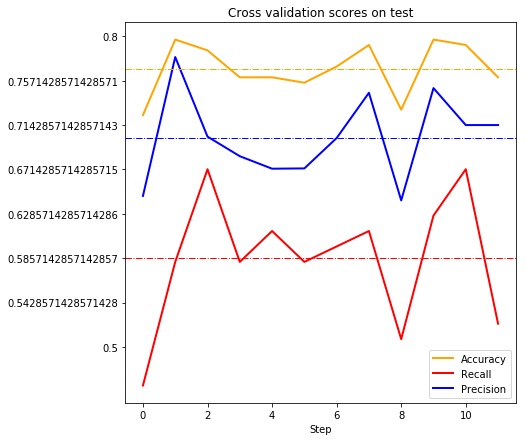

In [163]:
plt.figure(figsize=(7,7))

plt.plot(cv_metrics['test_accuracy'], color='Orange', linewidth=2)

plt.plot(cv_metrics['test_recall'], color='Red', linewidth=2)
plt.plot(cv_metrics['test_precision'], color='Blue', linewidth=2)

plt.axhline(cv_metrics['test_accuracy'].mean(), color='Orange', linewidth=1, linestyle='-.')
plt.axhline(cv_metrics['test_recall'].mean(), color='Red', linewidth=1, linestyle='-.')
plt.axhline(cv_metrics['test_precision'].mean(), color='Blue', linewidth=1, linestyle='-.')

yticks = np.linspace(0.5, 0.8, 8)
plt.yticks(np.)
plt.title('Cross validation scores on test')
plt.xlabel('Step')
plt.legend(['Accuracy', 'Recall', 'Precision']);

In [153]:

pd.DataFrame({
    'Mean':cv_metrics.mean(),
    'Standard Deviation':cv_metrics.std()
})


,Mean,Standard Deviation
test_accuracy,0.768663,0.025073
train_accuracy,0.774595,0.011440
test_precision,0.702084,0.042079
train_precision,0.709186,0.019622
test_recall,0.585821,0.062720
train_recall,0.600332,0.023077
